# GTSB Assignment Report

*Net Id : vvg239@nyu.edu*  
*Name : Vaibhav Vijay Gupta*    

The final accuracy that I achieved was **99.319%**. This accuracy was achieved using an **ensemble on DenseNet and MobileNet**, both trained from scratch. But to get to the final accuracy I tried out a whole lot of techniques. Below is a brief description of the techniques that I tried out along with code snippets about those. I have also included epoch vs accuracy/loss graph of the final ensemble.

## Technique 1
**(Extending the Self-Starter Code)**

The starter code provided on [GitHub](https://github.com/soumith/traffic-sign-detection-homework) took my first submission directly to somewhere around 90.9%. So the challenge was to improve on this. The first approach for this was to extend the provided model. The first few submissions included the following changes:
1. Add a layer of Conv2D layer. Adjust the number of fully connected cells accordingly. 

2. Add a layer of Fully Connected layer between the fc1 and fc2 layers already provided.

3. Added a BatchNorm2D layer directly after conv2. Batch norm normalizes the activations (mean 0) to tackle situations like dead ReLUs. It is like normalizing the input, just instead we normalize the activations here.
Code snippet:  

```python
    ##inside init
    self.conv2_bn = nn.BatchNorm2d(20)

    ##inside forward
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2_bn(self.conv2(x))), 2))
```

These techniques helped me get to **96.7%** accuracy.

## Technique 2
**(Using Pre-architectured Models)**

After extending the self-starter model with more Conv2D, FC and BatchNorm layers, I thought it would be a good idea to try out Data Augmentation. However, the extended self-starter model gave poor results on applying RandomRotation and RandomHorizontalFlip. Thus I felt the need to train a deeper (more robust) model before trying out Data Augmentation. 

I tried out the following models (in order) to see which gave best results:
1. MobileNet
2. ResNet
3. DenseNet
4. VGG
5. AlexNet
  
The first three gave the best results of the lot.   

An important thing to note is that I used *torchvision==0.4.1*. It seems that the architecture varies from version to version, so if you try to run my code, make sure torchvision is set to the right version.  

To use these pre-architectured models on GTSB, I had to move to using a custom classifier/fully-connected layer at the output end of the models. The code for ResNet is given below:  
```python
    model_resnet = torchvision.models.resnet18()

    ## Create a custom classifer with 43(num of GTSB classes) outputs. 
    custom_fc = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(512, 200)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(200, 43)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    model_resnet.fc = custom_fc

```

Also because these models have huge amounts of Conv layers (mostly without zero-padding), the minimum image dimensions needed are 224x224. I had to blow up the image sizes for the same. The changed data transformations looked like below:  
```python
    ## First resize the image to be 245x245. Then crop the 244x244 central part of image.
    data_transforms = transforms.Compose([transforms.Resize(245),
                                  transforms.CenterCrop(244),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))])
```

I tried a whole lot of techniques to train the model including trying out different learning rates and different optimizers like SGD, RMSProp, AdaGrad and Adam. Training Mobile Net with Adam Optimizer (learning rate 0.001 and 0.0001) got me the best performance. The prediction accuracy increased to **98.2%**.

## Technique 3
**(Data Augmentation and Preprocessing)**

Now that I had a sufficiently deep model it was time to again try out data augmentation. I applied `RandomRotation` and `RandomHorizontalFlip` transformations as follows:

```python
    data_transforms = transforms.Compose([transforms.RandomRotation(30),
                               transforms.Resize(255),
                               transforms.CenterCrop(244),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))])
```

Another technique that I tried applying was the **Sobel Operator**. More details about the operator [here](https://en.wikipedia.org/wiki/Sobel_operator). The code for it is below:
```python
    sobel_filter = torch.tensor([[-1., -2. , -1.], [0., 0., 0.], [1., 2. , 1.]])
    ## Expand to the 3 channels for our RGB image
    sobel_filter = sobel_filter.expand(1,3,3,3)
    ## Apply sobel filter in both training and evaluation methods
    images = nn.functional.conv2d(images, sobel_filter, stride=1, padding=1)
```  

Unfortunately both Data Augmentation and Sobel Operator didn't lead to any performance enhancement even after running MobileNet for around 100 epochs. This was very puzzling to me. I have a few conjectures on why this might have happened:
1. PyTorch doesn't augment the dataset with the transformed images. Rather it does random transformations on the fly. The dataset remains of the same size N instead of becoming 3N in our case. New transformations on every epoch might be causing our model to get confused. Using `torch.concatDatasets` I could have just added fixed randomly transformed images to my dataset, but I didn't get the time to explore this.
2. My reasoning behind using the Sobel Operator was that our signals are goemetric in shape and finding edges might help the model to perform better. However mostly the Sobel Operator is used when there is a lot of the same repeating background and our filters just end up fitting the background. This was not the case for our images. Sobel Operator might have just caused us to loose a lot of details in the model.  

I am not sure about the reasons stated above and would want to explore this more (time-permitting).

## Technique 4
**(Ensemble Models)**  

Ensembling is the final technique that I used to go beyond 99% accuracy. As mentioned above, MobileNet and DenseNet got me the best results on the GTSB. Now was the time to apply ensembles. Ensembles are a great way to prevent overfitting while introducting more dimensionality. This is because all the individual components of an ensemble are first trained separately and then their predictions are averaged. According to Andrej Karpathy in CS231n, ensembles are a great way to improve your model accuracy by around 2%.  

The backbone code for ensembling is as follows. Inside this, I plugin different ways of averaging the predictions of the individual models:
```python
    ## Pluging your logic to ensemble the individual models
    class MyEnsemble(nn.Module):
        def __init__(self, m1, m2):
            super(MyEnsemble, self).__init__()
            self.model1 = m1
            self.model2 = m2
            #Add more layers or weights or both

        def forward(self, x):
            out1 = self.model1(x)
            out2 = self.model2(x)
            #Add code to ensemble out1 and out2
            return out
```

As mentioned earlier, the models are trained individually and then the averaging is done on their predictions. As a result you might want to freeze their individual parameters, as follows:
```python
    for param in model.parameters():
        param.requires_grad = False
    
    # pass only the moving weights to the optimizer
    optimizer = optim.Adam(model.ensemble.parameters(), lr=lr)
```

I tried out the following methods of ensembling for achieving best results:

1. Add a linear layer that would take the model inputs and give the final predictions. Freeze the individual models and train only the linear layer.
```python
    #inside init
    self.linear1 = nn.Linear(86, 60) #GTSB has 43 classes. So the first linear layer will have 2*43 inputs
    self.linear2 = nn.Linear(60, 43)
    
    #inside forward
    out = F.relu(self.linear1(torch.cat((out1, out2), dim=1)))
    out = F.log_softmax(self.linear2(out), dim=1)
    
    model = MyEnsemble(model_resnet, model_mobilenet)
    params = list(model.linear1.parameters()) + list(model.linear2.parameters())
    optimizer = optim.Adam(params, lr=0.0001)
```
We initialize the individual models with the training checkpoints. After that you can either freeze the individual models and train only the fully connected layers or train the FC layers and the models both.  

2. Use weighted averages. Different classes of the same model could be scaled using different weights.
```python
    #inside init
    self.avg_weight = torch.nn.Parameter(torch.tensor([2,43], requires_grad=True))
    
    #inside forward
    out = self.avg_weights[0,:]*out1 + self.weights[1,:]*out2
    
    model = MyEnsemble(model_dense, model_mobilenet)
    optimizer = optim.Adam([list(model.parameters())[0]], lr=0.001)
```  

3. Use weighted averages but restrict the weights to one per model. All classes of the same model are scaled by the same weights.
```python
    #inside init
    self.avg_weight = torch.nn.Parameter(torch.tensor([0.5], requires_grad=True))
    
    #inside forward
    out = self.avg_weight[0]*out1 + (1-self.avg_weight[0])*out2
    
    model = MyEnsemble(model_dense, model_mobilenet)
    optimizer = optim.Adam([list(model.parameters())[0]], lr=0.001)
```  

Note : The averaging weights can be treated as either learned parameters or hyper-parameters.  

I tried all the above mentioned methods for different combinations of resnet, mobilenet and densenet. The best performance was achieved by taking weighted averages on the entire model outputs. I treated the weights as hyper-parameters and looped over a list of 50 values. The code is as follows:

```python
    for alpha in np.linspace(0,1,51):
        out = alpha*out1 + (1-alpha)*out2
```

The best value of the hyper-parameter `alpha` was *0.62* and this model got me an accuracy of **99.3%**.


<function matplotlib.pyplot.show(*args, **kw)>

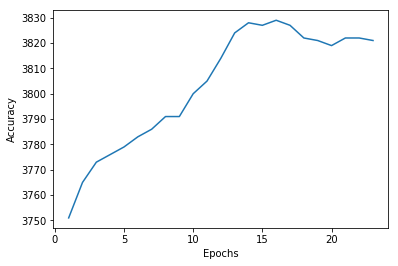

In [8]:
## Plot of Accuracy for the Ensemble Model

import matplotlib.pyplot as plt

accuracy = [3751,3765,3773,3776,3779,3783,3786,3791,3791,3800,3805,3814,3824,3828,3827,3829,3827,3822,3821,3819,3822,3822,3821]
epochs = list(range(1, 24))

plt.plot(epochs, accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show